In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available.")
    device = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available, using CPU instead.")
    device = torch.device("cpu")

GPU is available.
Using Tesla P100-PCIE-16GB


In [3]:
import string
import matplotlib.pyplot as plt

def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.split()
    return words

def create_vocabulary(words):
    vocab = sorted(set(words))
    word_to_index = {word: idx for idx, word in enumerate(vocab)}
    index_to_word = {idx: word for idx, word in enumerate(vocab)}
    return vocab, word_to_index, index_to_word

def one_hot_encode(word, word_to_index, vocab_size):
    vector = torch.zeros(vocab_size, device=device)
    index = word_to_index[word]
    vector[index] = 1
    return vector

def words_to_tensor(words, word_to_index, vocab_size, mode):
    tensors = [one_hot_encode(word, word_to_index, vocab_size) for word in words]
    if mode == 'rnn':
        return torch.stack(tensors)
    elif mode == 'lstm':
        return torch.stack(tensors).unsqueeze(1)

def text_to_tensor(file_path, mode):
    text = read_file(file_path)
    words = preprocess_text(text)
    vocab, word_to_index, index_to_word = create_vocabulary(words)
    vocab_size = len(vocab)
    input_tensor = words_to_tensor(words, word_to_index, vocab_size, mode)
    return input_tensor, vocab, word_to_index, index_to_word

def visualize(model):
    plt.figure(figsize=(12, 8))
    plt.plot(model.loss_history)
    plt.xlabel('Training Time')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.tight_layout()
    plt.show()

    for i, i2h_layer in enumerate(model.i2h):
        plt.figure(figsize=(12, 8))
        # 确保在取数据前将其移回 CPU
        plt.imshow(i2h_layer.weight.data.cpu().numpy(), cmap='hot', aspect='auto')
        plt.colorbar()
        plt.title(f'i2h Weight Matrix for Layer {i + 1}')
        plt.xlabel('Weight Index')
        plt.ylabel('Neuron Index')
        plt.tight_layout()
        plt.show()     

Epoch [10/300], Loss: 4.6339437496939375
Epoch [20/300], Loss: 4.046289846120879
Epoch [30/300], Loss: 2.3939775592106027
Epoch [40/300], Loss: 1.086879238698978
Epoch [50/300], Loss: 0.2819062105920247
Epoch [60/300], Loss: 0.09963748920417011
Epoch [70/300], Loss: 0.10267670529829999
Epoch 00079: reducing learning rate of group 0 to 1.0000e-04.
Epoch [80/300], Loss: 0.05442227138397711
Epoch [90/300], Loss: 0.0004539058563414814
Epoch [100/300], Loss: 0.000133119029859472
Epoch [110/300], Loss: 5.439047373235373e-05
Epoch [120/300], Loss: 2.5078668824636583e-05
Epoch [130/300], Loss: 1.2245591816984649e-05
Epoch [140/300], Loss: 6.01122038373496e-06
Epoch [150/300], Loss: 3.0811359738171907e-06
Epoch [160/300], Loss: 1.6490779429009202e-06
Epoch [170/300], Loss: 9.464655285582498e-07
Epoch [180/300], Loss: 5.479189036350362e-07
Epoch [190/300], Loss: 3.493108397048334e-07
Epoch [200/300], Loss: 2.5571773138978624e-07
Epoch [210/300], Loss: 1.874080628779264e-07
Epoch [220/300], Loss:

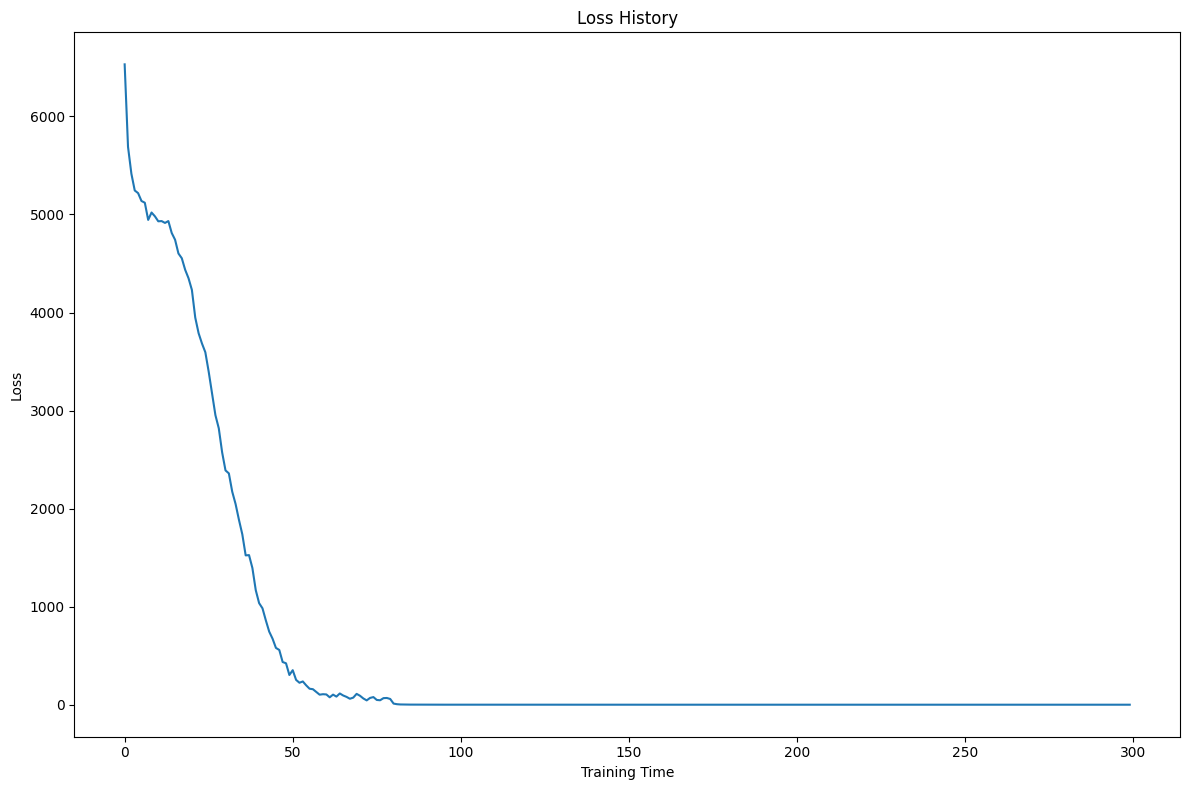

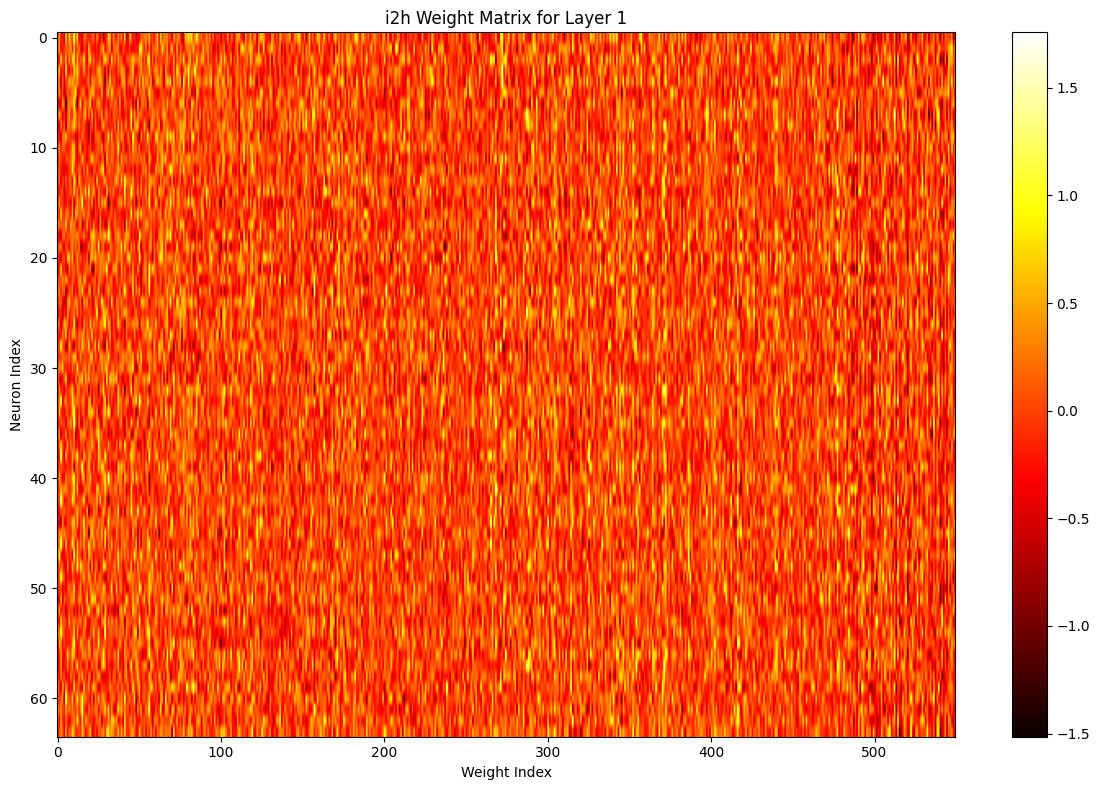

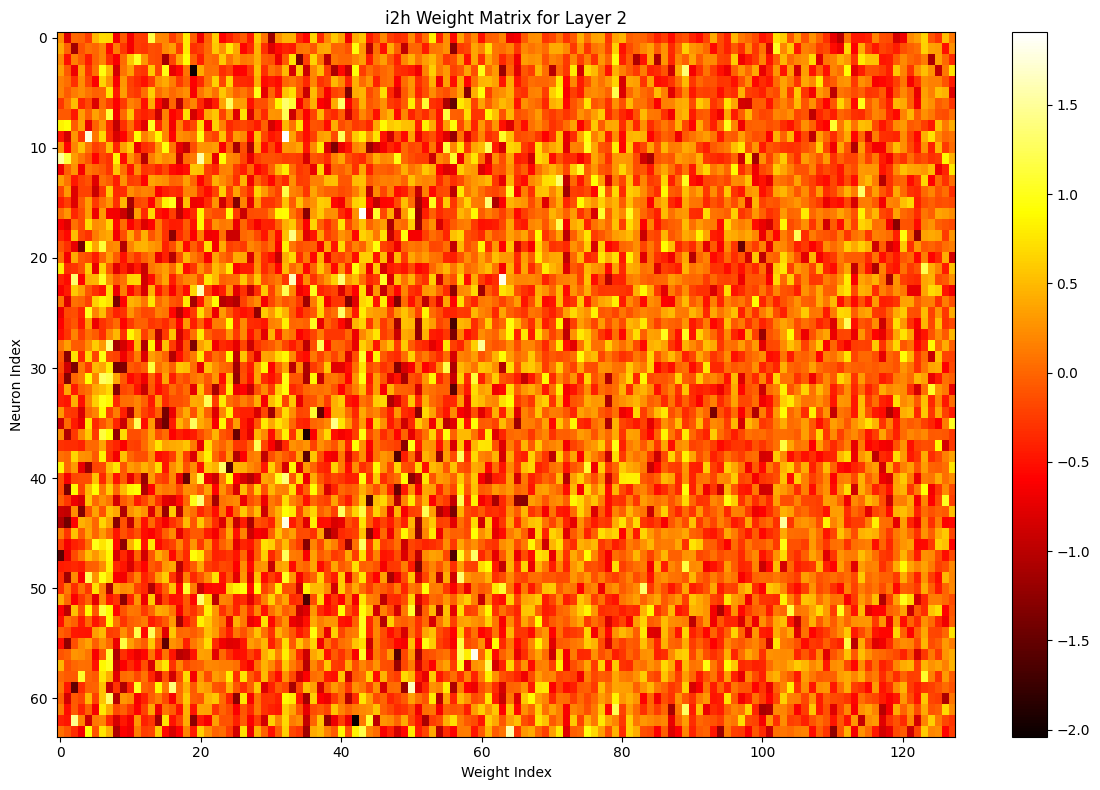

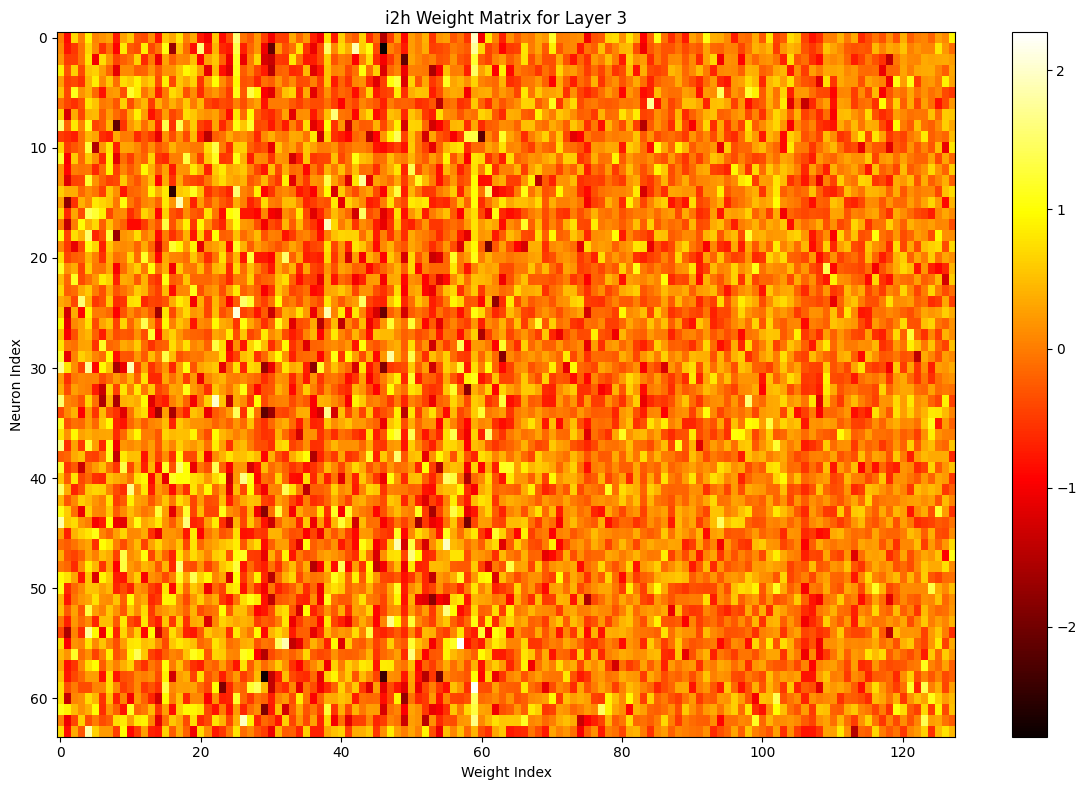

In [4]:
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 确保第一层可以接受input_size + hidden_size大小的输入，后续层只接受hidden_size大小的输入
        self.i2h = nn.ModuleList([nn.Linear(input_size + hidden_size if i == 0 else 2 * hidden_size, hidden_size) for i in range(num_layers)])
        self.f2h = nn.ModuleList([nn.Linear(input_size + hidden_size if i == 0 else 2 * hidden_size, hidden_size) for i in range(num_layers)])
        self.c2h = nn.ModuleList([nn.Linear(input_size + hidden_size if i == 0 else 2 * hidden_size, hidden_size) for i in range(num_layers)])
        self.o2h = nn.ModuleList([nn.Linear(input_size + hidden_size if i == 0 else 2 * hidden_size, hidden_size) for i in range(num_layers)])
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.loss_history = []

    def forward(self, input_tensor, hidden_tensors, cell_tensors):
        new_hidden_tensors = []
        new_cell_tensors = []

        for i in range(self.num_layers):
            hidden_expanded = hidden_tensors[i].unsqueeze(0)
            cell_expanded = cell_tensors[i].unsqueeze(0)
            combined = torch.cat((input_tensor, hidden_expanded), 2)
            input_gate = torch.sigmoid(self.i2h[i](combined))
            forget_gate = torch.sigmoid(self.f2h[i](combined))
            cell_gate = torch.tanh(self.c2h[i](combined))
            output_gate = torch.sigmoid(self.o2h[i](combined))

            cell = forget_gate * cell_expanded + input_gate * cell_gate
            hidden = output_gate * torch.tanh(cell)

            new_hidden_tensors.append(hidden.squeeze(0))
            new_cell_tensors.append(cell.squeeze(0))

            input_tensor = hidden  # Update the input tensor for the next layer

        output = self.i2o(input_tensor.squeeze(0))
        output = self.softmax(output)
        return output, new_hidden_tensors, new_cell_tensors

    def init_hidden(self):
        return [torch.zeros(1, self.hidden_size, device=device) for _ in range(self.num_layers)], [torch.zeros(1, self.hidden_size, device=device) for _ in range(self.num_layers)]

    def train_model(self, data, num_epochs=10, lr=0.01):
        self.loss_history = []
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

        for epoch in range(num_epochs):
            total_loss = 0
            hidden_tensors, cell_tensors = self.init_hidden()

            for i in range(data.size(0) - 1):
                input_tensor = data[i].unsqueeze(0).to(device)
                target_tensor = torch.tensor([torch.argmax(data[i + 1])], dtype=torch.long).to(device)

                output, hidden_tensors, cell_tensors = self(input_tensor, [h.detach() for h in hidden_tensors], [c.detach() for c in cell_tensors])
                loss = criterion(output, target_tensor)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / (data.size(0) - 1)
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}')
            self.loss_history.append(total_loss)
            scheduler.step(avg_loss)


file_path = '/kaggle/input/input-data/input.txt'
input_tensor, vocab, word_to_index, _ = text_to_tensor(file_path, 'lstm')
input_tensor = input_tensor.to(device)
input_size = len(vocab)
output_size = len(vocab)
hidden_size = 64
num_layers = 3
num_epochs = 300
learning_rate = 1e-3

lstm = LSTM(input_size=input_size,
            hidden_size=hidden_size,
            output_size=output_size,
            num_layers=num_layers).to(device)

lstm.train_model(input_tensor, num_epochs=num_epochs, lr=learning_rate)
visualize(lstm)
torch.save(lstm, 'lstm.pth')